# Import and definitions

In [1]:
import sys
import zmq
import uuid
import glob
import yaml
from numpy import pi
import numpy as np
import qutip as qt

reconnect = False

# Specify initial pulse and bounds

In [10]:
handmade_pulse = {
        'control1': {
            'carrier1': {
                'freq': 6e9*2*pi,
                'pulses': {
                    'pulse1': {
                        'amp': 15e6*2*pi,
                        't_up': 5e-9,
                        't_down': 45e-9,
                        'xy_angle': 0
                        }
                    }
                }
            }
        }
pulse_bounds = {
        'control1': {
            'carrier1': {
                'freq': [1e9*2*pi, 15e9*2*pi],
                'pulses': {
                    'pulse1': {
                        'amp':  [1e3*2*pi, 10e9*2*pi],
                        't_up': [2e-9, 98e-9],
                        't_down': [2e-9, 98e-9],
                        'xy_angle': [-pi, pi]
                        }
                    }
                }
            }
        }

# Evaluation function

Provide a function, specific to your experimental setup, that takes a several sets of parameters and provides a figure of merit for each.

In [29]:
def evaluate_pulse(gate, samples):
    global search_id
    infidelities = []
    for q in samples:
        pulse_id = str(uuid.uuid4())
        gate.print_pulse(q)
        gate.plot_control_fields(q)
        pulse = gate.get_IQ(q)
        T_final = gate.T_final
        ts = np.linspace(0, T_final, T_final*1e9)
        Is = pulse['I'](ts)
        Qs = pulse['Q'](ts)
        non0_mask = np.nonzero(Is * Qs) 
        pulse['I'] = list(Is[non0_mask])  
        pulse['Q'] = list(Qs[non0_mask])
        request = {
                'search_id': search_id,
                'pulse_id': pulse_id,
                'pulse': pulse,
                'fidelity': 0,
                'do_stop': False
                }
        
        socketreq.send_json(request)
        receive_message = socketreq.recv_string()
        
        reply = socketrep.recv_json()
        socketrep.send_string(search_id)    

        # Extract the fidelity
        infidelities.append(1-reply['fidelity'])
    return infidelities

# Import C3PO

In [30]:
from c3po.main.gate import Gate as gt
from c3po.fidelity.measurement import Experiment as exp_backend

In [31]:
X_gate = gt('qubit_1', qt.sigmax())
X_gate.set_parameters('initial', handmade_pulse)
X_gate.set_bounds(pulse_bounds)

fridge = exp_backend(evaluate_pulse)

# Communication setup
Replace '127.0.0.1' with the IP of the LabView machine. Hostnames might confuse the queue interface.

In [38]:
calibration_daemon_experiment_URI = "tcp://127.0.0.1:5559"
calibration_daemon_searcher_URI = "tcp://127.0.0.1:5560"

if reconnect:
    socketreq.unbind(calibration_daemon_experiment_URI)
    socketrep.close()

rcvtimeout = 30000
search_id = str(uuid.uuid4())
print(f"I am the calibration searcher.\nMy ID for this run is {search_id}\n")

# Start communication
print(f"Connecting to client {calibration_daemon_experiment_URI} ... ", flush=True, end='')
context = zmq.Context()
socketrep = context.socket(zmq.REP)

socketrep.bind(calibration_daemon_searcher_URI)

socketreq = context.socket(zmq.REQ)
socketreq.setsockopt(zmq.LINGER, 0)  #NEW Added by Edwar to flush the queue
socketreq.connect(calibration_daemon_experiment_URI)

socketrep.RCVTIMEO = rcvtimeout  # added timeout to kill rcv if nothing comes
socketreq.RCVTIMEO = rcvtimeout
print(f"done\n\n", flush=True)
reconnect = True

I am the calibration searcher.
My ID for this run is 5ed8fd9a-7dbe-4270-9872-7e5fd0b9ec6f

Connecting to client tcp://127.0.0.1:5559 ... done




# Calibration

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=550567, Tue May 21 18:46:06 2019)
{
    "control1": {
        "carrier1": {
            "freq": 21446496265.860058,
            "pulses": {
                "pulse1": {
                    "amp": 4284235315.552861,
                    "t_down": 3.4515132981982545e-08,
                    "t_up": 1.0774129719360074e-08,
                    "xy_angle": -0.5373725183588056
                }
            }
        }
    }
}


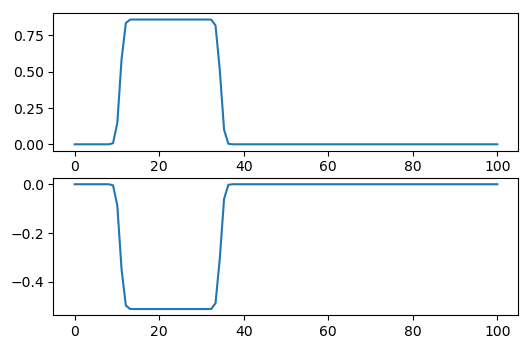

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


{
    "control1": {
        "carrier1": {
            "freq": 23269311070.773525,
            "pulses": {
                "pulse1": {
                    "amp": 14266916139.369673,
                    "t_down": 5.828467741168205e-08,
                    "t_up": 1.756936534300884e-08,
                    "xy_angle": -1.5930192862882693
                }
            }
        }
    }
}


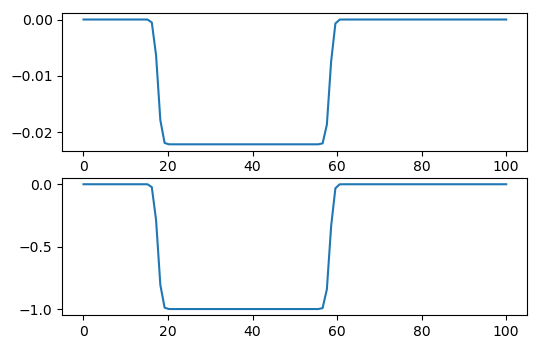

KeyboardInterrupt: 

In [39]:
fridge.calibrate(X_gate)